In [1]:
%matplotlib inline

from __future__ import print_function
from matplotlib import pyplot as plt

import numpy as np
import cv2 

Reading reference image :  Images/stitched_cloudy_small.jpg
Reading image to align :  Images/drone_1_small.jpg
Aligning images ...


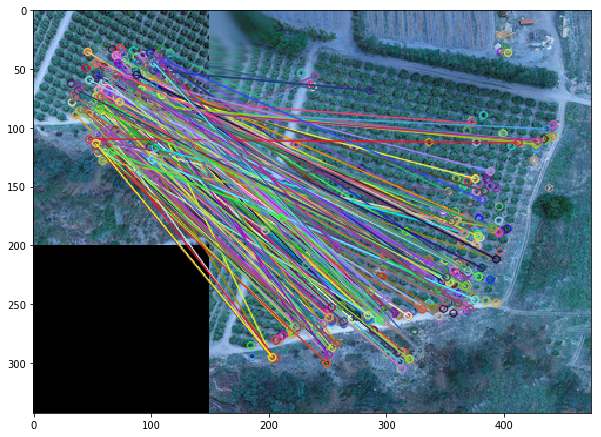

MAP: Calculated scale difference: 1.25, Calculated rotation difference: 8.32
Saving aligned image :  Outputs/aligned.jpg
Estimated homography : 
 [[ 1.24117683e+00  1.81602366e-01  5.70719770e+00]
 [-2.03917411e-01  9.35374453e-01  1.86359648e+02]
 [-1.50764288e-05 -4.83405215e-04  1.00000000e+00]]


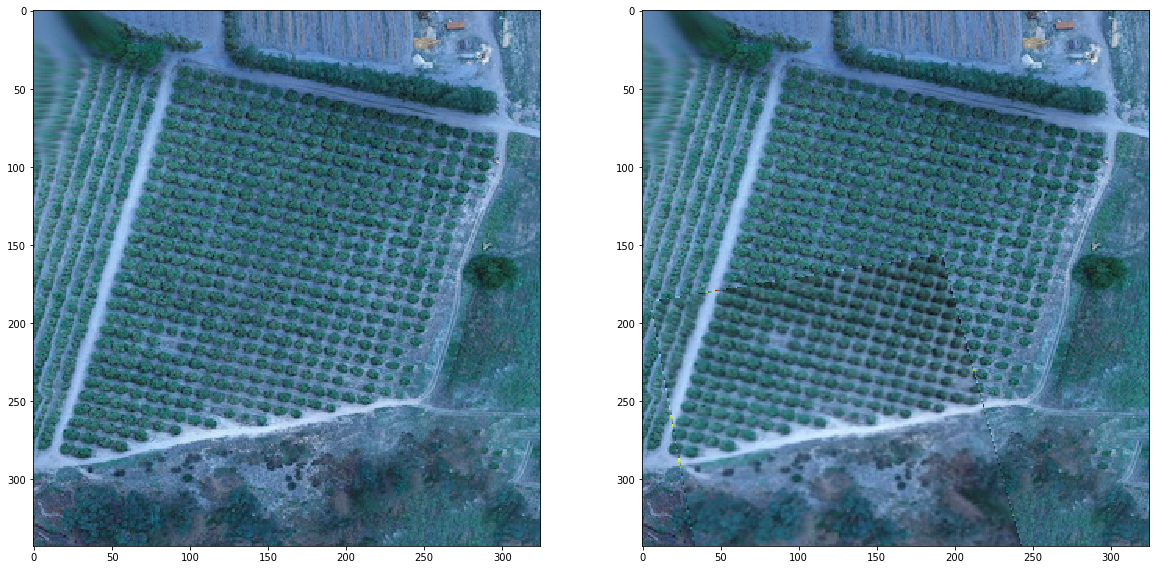

In [2]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.7
 
def alignImages(im1, im2):
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
#     thresh = 125
#     maxValue = 255
 
#     # Basic threshold to binary image
#     th, im1Bin = cv2.threshold(im1Gray, thresh, maxValue, cv2.THRESH_BINARY);
#     th, im2Bin = cv2.threshold(im2Gray, thresh, maxValue, cv2.THRESH_BINARY);
#     cv2.imwrite("bin.jpg", im1Bin)
   
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
   
    # Match features.
#     matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
   
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # Remove bad matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
 
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("Outputs/matches.jpg", imMatches)
        
    fig = plt.figure(figsize=(10,10))
    plt.imshow(imMatches)
    plt.show()
   
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
   
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    
    #ref is im2
    imgMask = np.ones(im1.shape, dtype=np.uint8)
    imgMaskWarped = cv2.warpPerspective(imgMask, h, (width, height));
    imgMaskWarped = np.floor(cv2.bitwise_not(imgMaskWarped) / 255)

    im1Reg = im2 * (imgMaskWarped.astype(im2.dtype)) + im1Reg
   
    return im1Reg, h
  
if __name__ == '__main__':
   
    # Read reference image
    refFilename = "Images/stitched_cloudy_small.jpg"
    print("Reading reference image : ", refFilename)
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
 
    # Read image to be aligned
    imFilename = "Images/drone_1_small.jpg"
    print("Reading image to align : ", imFilename);  
    im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    
    print("Aligning images ...")
    # Registered image will be stored in imReg. 
    # The estimated homography will be stored in h. 
    imReg, h = alignImages(im, imReference)
    
    ss = h[0, 1]
    sc = h[0, 0]
    scaleRecovered = np.sqrt(ss * ss + sc * sc)
    thetaRecovered = np.arctan2(ss, sc) * 180 / np.pi
    print("MAP: Calculated scale difference: %.2f, "
                  "Calculated rotation difference: %.2f" %
                  (scaleRecovered, thetaRecovered))
   
    # Write aligned image to disk. 
    outFilename = "Outputs/aligned.jpg"
    print("Saving aligned image : ", outFilename); 
    cv2.imwrite(outFilename, imReg)
     
    # Print estimated homography
    print("Estimated homography : \n",  h)
    
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(1,2,1)
    plt.imshow(imReference)
    fig.add_subplot(1,2,2)
    plt.imshow(imReg)
        
    plt.show()